# Metadata

1. age: in years
2. sex: (M = male; F = female)
3. cp: chest pain type
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholesterol in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
8. thalach: maximum heart rate achieved
9. nar: number of arms
10. exang: exercise induced angina (1 = yes; 0 = no)
11. oldpeak: ST depression induced by exercise relative to rest
12. slope: the slope of the peak exercise ST segment
13. hc: patient's hair colour
14. sk: patient's skin colour
15. trf: time spent in traffic daily (in seconds)
16. ca: number of major vessels (0-3) colored by flourosopy
17. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

### Categorical features:

binary: ['sex', 'fbs', 'exang']

three_classes: ['restecg', 'slope', 'nar', 'hc']

four_classes: ['thal', 'sk', 'ca']

all categorical features: ['sex', 'fbs', 'restecg', 'exang', 'slope' 'ca', 'thal', 'nar', 'hc', 'sk']

---

In [1]:
# libs
import os
import pickle
import numpy
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns; sns.set(style="whitegrid")
import pydotplus
from pdpbox import info_plots
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import catboost

---

# Functions

In [2]:
def downsampling(df_):
    """ Randomly remove observations from the majority class to prevent its signal from dominating the learning algorithm. """
    
    df_ = df_.copy()
    
    # Separate majority and minority classes
    df_majority = df_[df_.sex==1]
    df_minority = df_[df_.sex==0]
        
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=df_minority.shape[0],     # to match minority class
                                     random_state=42) # reproducible results

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    return df_downsampled

In [3]:
def upsampling(df_):
    """ Randomly duplicating observations from the minority class in order to reinforce its signal. """
    
    df_ = df_.copy()

    # Separate majority and minority classes
    df_majority = df_[df_.sex==1]
    df_minority = df_[df_.sex==0]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority,
                                     replace=True,     # sample with replacement
                                     n_samples=df_majority.shape[0],    # to match majority class
                                     random_state=42) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    return df_upsampled

In [4]:
def ohe(df_, columns, save_encoder=False):
    """ One hot encode columns in the dataframe df_ and save a encoder as a pickle file. """
    
    df_ = df_.copy()

    # separate two dfs: df_ is not to encode and df_to_encode is to encode
    df_not_to_encode = df_.drop(columns=columns)
    df_to_encode = df_[columns]

    # one hot encoding
    enc = OneHotEncoder()
    enc.fit(df_to_encode)

    if save_encoder==True:
        # save to pickle file (used in production)
        with open('encoder', 'wb') as f:
            pickle.dump(enc, f)

    # with open('/home/sirius/Documents/workspace/desafio_ds/encoder', 'rb') as f:
    #     enc = pickle.load(f)

    data = enc.transform(df_to_encode).toarray()
    columns = enc.get_feature_names(columns)
    df_to_encode = pd.DataFrame(data=data, columns=columns, index=df_.index, dtype=int)

    # concatenate data
    df_encoded = pd.concat([df_not_to_encode, df_to_encode], axis=1)
    
    return df_encoded

---

# Open the data

In [5]:
# base dir
BASE_DIR = os.getcwd()

In [6]:
# open dataset
DIR_FILE = os.path.join(BASE_DIR, "EnviarAoCandidato", "test_data_CANDIDATE.csv")
df = pd.read_csv(DIR_FILE, index_col='index')
df.shape

(288, 17)

Dataset has 288 samples and 17 features

In [7]:
# first lines
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,nar,hc,sk,trf
index,,,,,,,,,,,,,,,,,
0,49,M,10000,130,269.0,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,61,F,10000,138,166.0,0,0,125,1,3.6,NaN,1,2,2,1,3,4307.686943
2,46,F,10000,140,311.0,0,1,120,1,1.8,NaN,2,3,2,0,1,4118.077502
3,69,F,10000,140,254.0,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,51,F,10000,100,222.0,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145


In [8]:
# feature types
df.dtypes

age           int64
sex          object
cp            int64
trestbps      int64
chol        float64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope       float64
ca            int64
thal          int64
nar           int64
hc            int64
sk            int64
trf         float64
dtype: object

All columns are numeric, except 'sex' (target), which is actually text, although python has loaded it as a generic object.

## 'sex' column (target)

In [9]:
df.sex.value_counts()

F    194
M     91
f      2
m      1
Name: sex, dtype: int64

### Unbalanced dataset

'sex' has more observations for female than male.

There are some lowercase letters in 'sex', it's possible that it was typed wrong.

Algorithms usually work with numbers, so let's convert 'M' and 'm' to 0 and 'F' and 'f' to 1.

In [10]:
df['sex'] = df['sex'].map({'M': '0', 'm': '0', 'F': '1', 'f': '1'})
df['sex'] = df['sex'].astype('int')

In [11]:
df.sex.value_counts()

1    196
0     92
Name: sex, dtype: int64

---

# Train-test split

Separa um conjunto de teste para avaliação final, após a modelagem e as otimizações.

Devido ao desbalanceamento dos dados, alguma técnica de balanceamento será utilizada (upsampling ou downsampling) e então serão separados quantidades iguais de dados para cada classe (M ou F) no conjunto teste

Como o dataset possui somente 288 amostras, somente 15% será para o teste final, ou seja, 40 amostras

In [12]:
0.15*df.shape[0]

43.199999999999996

In [13]:
# split the dataset into df_train and df_test

df_f = df[df.sex==1]
df_f_train, df_f_test = train_test_split(df_f, test_size=20, random_state=42)

df_m = df[df.sex==0]
df_m_train, df_m_test = train_test_split(df_m, test_size=20, random_state=42)

df_train = pd.concat([df_m_train, df_f_train])
df_test = pd.concat([df_m_test, df_f_test])
print(f'df_train.shape: {df_train.shape}')
print(f'df_test.shape: {df_test.shape}')

df_train.shape: (248, 17)
df_test.shape: (40, 17)


---

# Missing data (NaN)

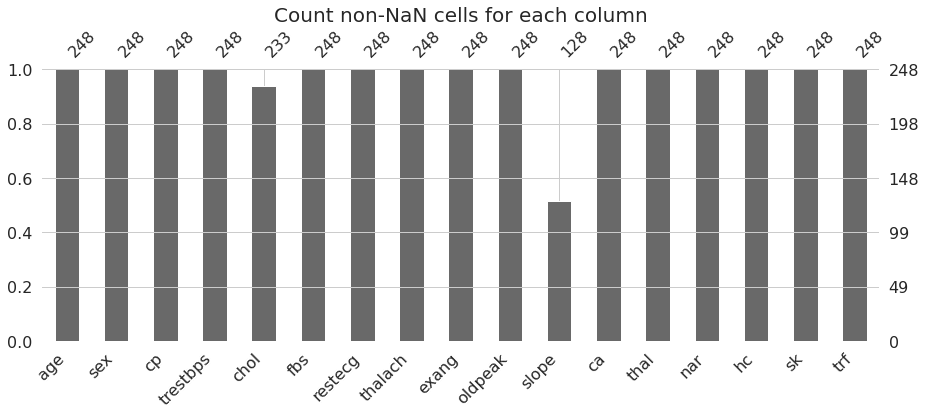

In [14]:
msno.bar(df_train, figsize=(15,5))
plt.title('Count non-NaN cells for each column', fontsize=20)
plt.show()

In [15]:
# Count of NaN
df_train.isna().sum()

age           0
sex           0
cp            0
trestbps      0
chol         15
fbs           0
restecg       0
thalach       0
exang         0
oldpeak       0
slope       120
ca            0
thal          0
nar           0
hc            0
sk            0
trf           0
dtype: int64

In [16]:
# % of NaN
100*df_train.isna().sum()/df_train.shape[0]

age          0.000000
sex          0.000000
cp           0.000000
trestbps     0.000000
chol         6.048387
fbs          0.000000
restecg      0.000000
thalach      0.000000
exang        0.000000
oldpeak      0.000000
slope       48.387097
ca           0.000000
thal         0.000000
nar          0.000000
hc           0.000000
sk           0.000000
trf          0.000000
dtype: float64

'slope' has 120 NaNs (48,3%)

'chol' possui 15 NaNs (6,04%)

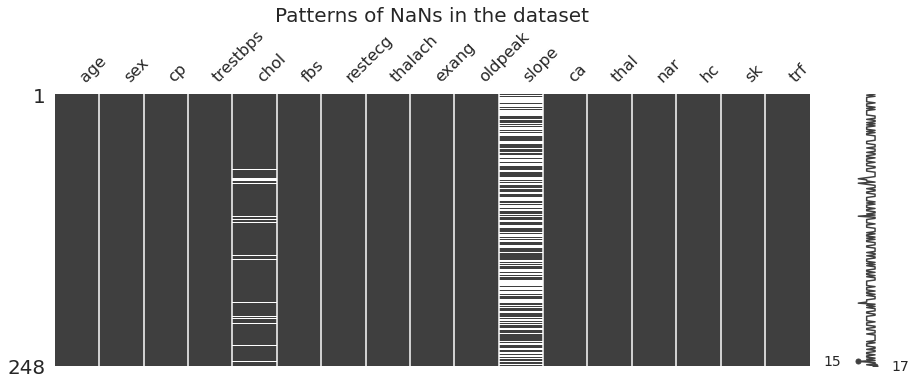

In [17]:
msno.matrix(df_train, figsize=(15,5))
plt.title('Patterns of NaNs in the dataset', fontsize=20)
plt.show()

The matrix show that there aren't a pattern of NaNs among the features.

Only some observations have NaNs in the same time in 'chol' and 'slope'

---

# Preprocessing

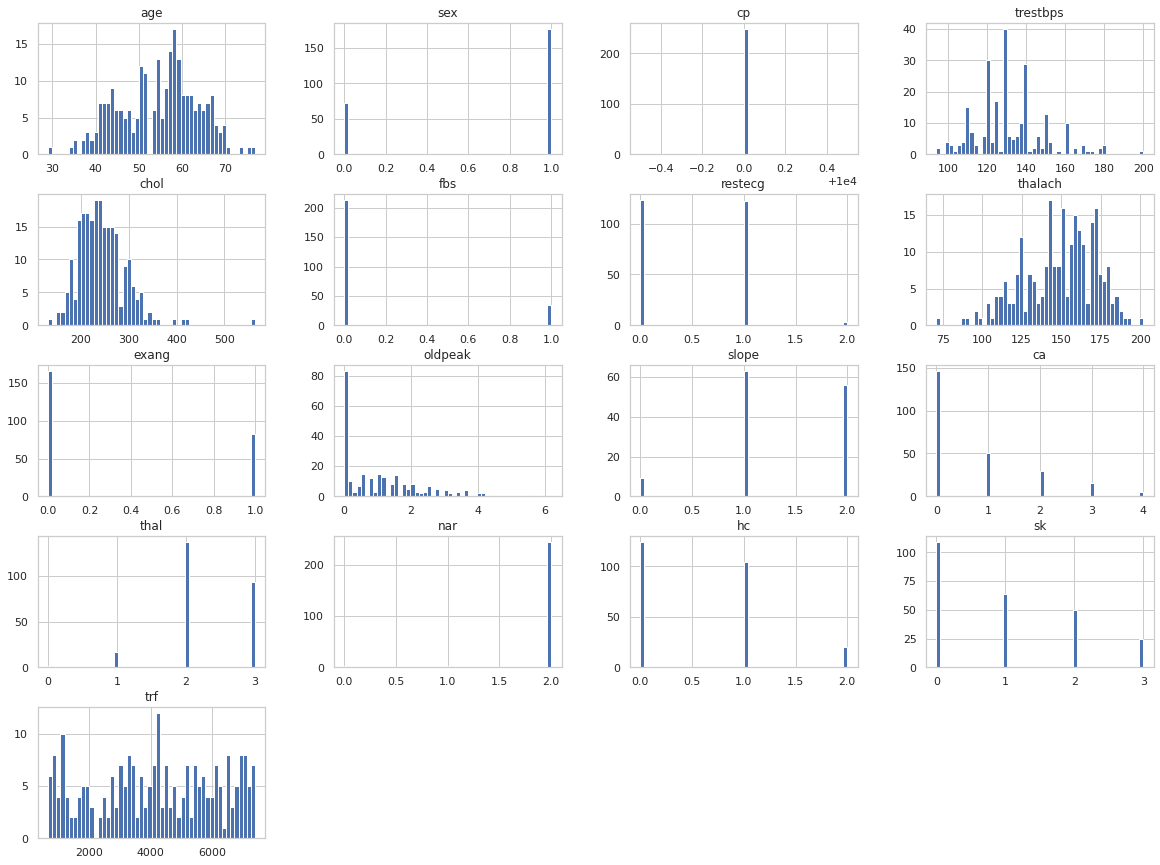

In [18]:
df_train.hist(bins=50, figsize=(20,15))
plt.show()

'cp' has constant value and can be dropped because it provides no information.


In [19]:
df_train.drop('cp', axis='columns', inplace=True)

'ca' (0-3) has values (0-4). Some cells have a value of 4, which will be replaced by 0, which is the most common value for this feature.

In [20]:
df_train.loc[df_train[df_train.ca==4].index, 'ca'] = 0

'slope' has 49,6% of NaN and by now it can be dropped.

It could be filled with another value, maybe with the most common or a value predicted from a model created with the other features.

It also could be transformed in a binary feature, with the meaning of has or not NaN.

In [21]:
df_train.drop('slope', axis='columns', inplace=True)

NaNs in 'chol' can be filled with median or mean. Let's use the median, because it is less affected by outliers than the mean.

In [22]:
# df.boxplot(column='chol', by='sex')
# plt.show()

chol_median_m = df_train[df_train.sex==0].chol.median()
df_train.update(df_train[df_train.sex==0][['chol']].fillna(chol_median_m))

chol_median_f = df_train[df_train.sex==1].chol.median()
df_train.update(df_train[df_train.sex==1][['chol']].fillna(chol_median_f))

- 'restect' (resting electrocardiographic results) está sem metadados, porém em dataset similar na internet consta: (0 = normal; 1 = having ST-T; 2 = hypertrophy)
- thal (3, 6, 7) está com (0, 1, 2, 3)
- 'nar' can be transformed to a boolean feature with the meaning has 2 arms or don't.

<AxesSubplot:>

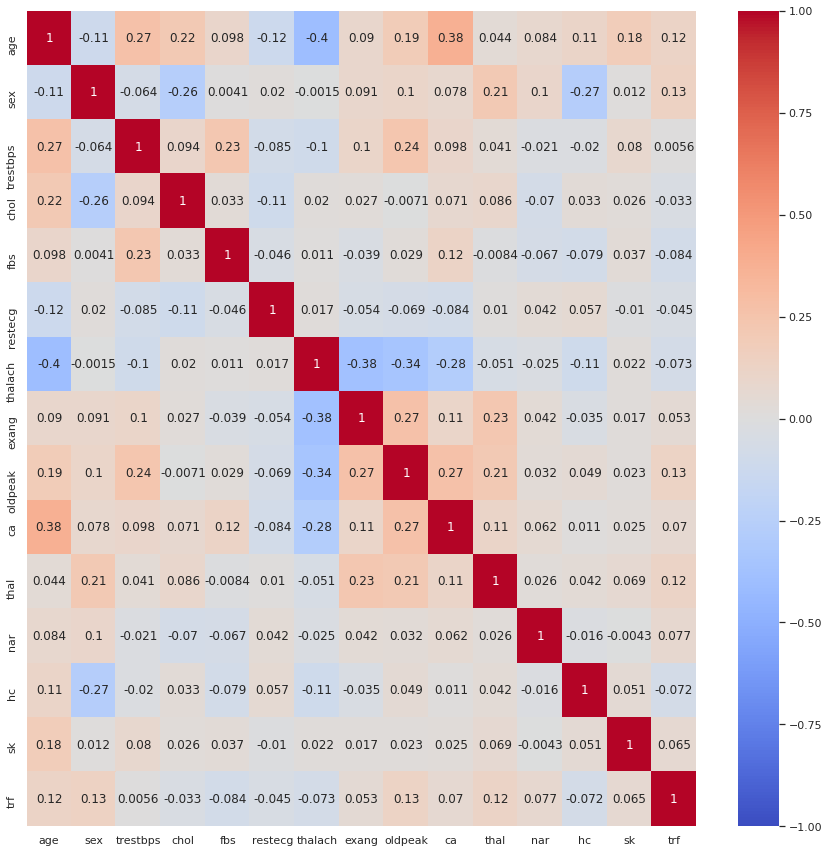

In [23]:
plt.figure(figsize=(15,15))
sns.heatmap(df_train.corr(), vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt='.2g')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


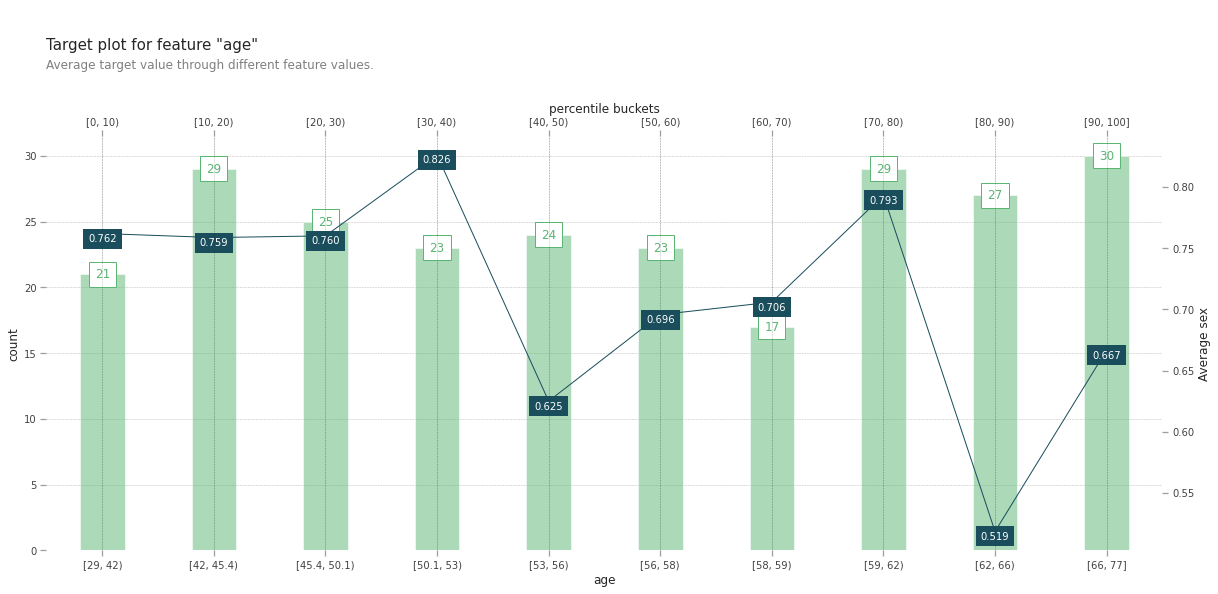

In [24]:
fig, axes, summary_df = info_plots.target_plot(df=df_train,
                                               feature='age',
                                               feature_name='age',
                                               target='sex',
                                               show_percentile=True,
                                               num_grid_points=11,
                                               figsize=(20,10))

Independent of the age, the average sex is always greater than 0.5.

This is probably because on 'sex' column, there are more class 1 (female) than class 0 (male)

In [25]:
df_m = df_train.loc[df.sex==0]
df_f = df_train.loc[df.sex==1]

In [26]:
df_m.describe()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,thal,nar,hc,sk,trf
count,72.000000,72.0,72.000000,72.000000,72.000000,72.00000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,56.125000,0.0,133.416667,264.361111,0.138889,0.50000,149.444444,0.263889,0.890278,0.527778,2.097222,1.944444,0.847222,0.944444,3743.269926
std,8.879376,0.0,20.328811,66.520632,0.348257,0.55665,19.908869,0.443833,1.154801,0.871654,0.449091,0.285267,0.493899,1.019374,1902.854842
min,37.000000,0.0,94.000000,149.000000,0.000000,0.00000,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,763.348099
25%,50.750000,0.0,120.000000,215.750000,0.000000,0.00000,138.250000,0.000000,0.000000,0.000000,2.000000,2.000000,1.000000,0.000000,2048.856624
50%,57.000000,0.0,130.000000,252.000000,0.000000,0.00000,153.500000,0.000000,0.600000,0.000000,2.000000,2.000000,1.000000,1.000000,3744.362092
75%,62.250000,0.0,140.000000,297.000000,0.000000,1.00000,163.000000,1.000000,1.400000,1.000000,2.000000,2.000000,1.000000,2.000000,5139.970918
max,76.000000,0.0,200.000000,564.000000,1.000000,2.00000,179.000000,1.000000,6.200000,3.000000,3.000000,2.000000,2.000000,3.000000,7389.481550


In [27]:
df_f.describe()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,thal,nar,hc,sk,trf
count,176.000000,176.0,176.0000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,53.926136,1.0,130.9375,235.295455,0.142045,0.522727,149.369318,0.357955,1.161364,0.687500,2.380682,1.988636,0.471591,0.971591,4334.345062
std,9.008580,0.0,16.4630,38.541009,0.350093,0.512189,24.142315,0.480766,1.199422,0.949624,0.648049,0.150756,0.658387,1.027780,2012.488329
min,29.000000,1.0,94.0000,131.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,653.415425
25%,47.000000,1.0,120.0000,208.000000,0.000000,0.000000,132.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,2852.037017
50%,54.500000,1.0,130.0000,233.000000,0.000000,1.000000,150.500000,0.000000,0.850000,0.000000,2.000000,2.000000,0.000000,1.000000,4401.840239
75%,60.000000,1.0,140.0000,259.250000,0.000000,1.000000,169.000000,1.000000,1.900000,1.000000,3.000000,2.000000,1.000000,2.000000,6109.224221
max,77.000000,1.0,180.0000,335.000000,1.000000,2.000000,202.000000,1.000000,5.600000,3.000000,3.000000,2.000000,2.000000,3.000000,7385.288380


---

# Test some classification algorithms

Let's get an idea of which model is more promising

## Decision tree using unbalanced data

In [28]:
X = df_train.drop(columns='sex')
y = df_train['sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (198, 14)
y_train.shape: (198,)
X_test.shape: (50, 14)
y_test.shape: (50,)


In [29]:
y_train.value_counts(normalize=True)

1    0.712121
0    0.287879
Name: sex, dtype: float64

70% of the observations belong to class 1 (female)

In [30]:
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.53      0.50        15
           1       0.79      0.74      0.76        35

    accuracy                           0.68        50
   macro avg       0.63      0.64      0.63        50
weighted avg       0.69      0.68      0.69        50



As expected, the model perform better to class 1 (Female), because there are more data to this class

## Decision tree using downsampling and One Hot Encoding (OHE)

In [31]:
COLUMNS_TO_ENCODE = ['restecg', 'ca', 'thal', 'nar', 'hc', 'sk'] # cat features with two and three classes
df_encoded = ohe(df_train, columns=COLUMNS_TO_ENCODE)

In [32]:
df_sampled = downsampling(df_encoded)

X = df_sampled.drop(columns='sex')
y = df_sampled['sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (115, 29)
y_train.shape: (115,)
X_test.shape: (29, 29)
y_test.shape: (29,)


In [33]:
y_train.value_counts(normalize=True)

1    0.504348
0    0.495652
Name: sex, dtype: float64

Classes are balanced

In [34]:
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        15
           1       0.71      0.71      0.71        14

    accuracy                           0.72        29
   macro avg       0.72      0.72      0.72        29
weighted avg       0.72      0.72      0.72        29



With balanced data, metrics for each class are similar

## Decision Tree using Upsampling and One Hot Encoding (OHE)

In [35]:
COLUMNS_TO_ENCODE = ['restecg', 'ca', 'thal', 'nar', 'hc', 'sk'] # cat features with two and three classes
df_encoded = ohe(df_train, columns=COLUMNS_TO_ENCODE, save_encoder=True)

In [36]:
df_sampled = upsampling(df_encoded)

X = df_sampled.drop(columns='sex')
y = df_sampled['sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (281, 29)
y_train.shape: (281,)
X_test.shape: (71, 29)
y_test.shape: (71,)


In [37]:
y_train.value_counts(normalize=True)

1    0.501779
0    0.498221
Name: sex, dtype: float64

Classes are balanced

In [38]:
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85        36
           1       0.96      0.69      0.80        35

    accuracy                           0.83        71
   macro avg       0.86      0.83      0.83        71
weighted avg       0.86      0.83      0.83        71



Results are better in upsampling than downsampling. So, let's continue using upsampling

## RandomForestClassifier using upsampling and OHE

In [39]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        36
           1       0.93      0.77      0.84        35

    accuracy                           0.86        71
   macro avg       0.87      0.86      0.86        71
weighted avg       0.87      0.86      0.86        71



## Logistic Regression using upsampling and OHE

In [40]:
clf = LogisticRegression(max_iter=900, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        36
           1       0.68      0.71      0.69        35

    accuracy                           0.69        71
   macro avg       0.69      0.69      0.69        71
weighted avg       0.69      0.69      0.69        71



## LGBMClassifier using upsampling and OHE

In [41]:
clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        36
           1       0.93      0.80      0.86        35

    accuracy                           0.87        71
   macro avg       0.88      0.87      0.87        71
weighted avg       0.88      0.87      0.87        71



## SVC using upsampling and OHE

In [42]:
clf = SVC(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.67      0.64        36
           1       0.62      0.57      0.60        35

    accuracy                           0.62        71
   macro avg       0.62      0.62      0.62        71
weighted avg       0.62      0.62      0.62        71



## KNeighborsClassifier using upsampling and OHE

In [43]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70        36
           1       0.70      0.66      0.68        35

    accuracy                           0.69        71
   macro avg       0.69      0.69      0.69        71
weighted avg       0.69      0.69      0.69        71



## GradientBoostingClassifier using upsampling and OHE

In [44]:
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.97      0.89        36
           1       0.96      0.77      0.86        35

    accuracy                           0.87        71
   macro avg       0.89      0.87      0.87        71
weighted avg       0.89      0.87      0.87        71



## CatBoostClassifier using upsampling and OHE

https://catboost.ai/docs/concepts/parameter-tuning.html says: Don't use one-hot encoding during preprocessing. This affects both the training speed and the resulting quality.

So, for this algorithm a specific df_sampled will be created

In [45]:
df_sampled_cb = upsampling(df_train) # df sampled to use in CatBoostClassifier.

X_cb = df_sampled_cb.drop(columns='sex')
y_cb = df_sampled_cb['sex']

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, test_size=0.2, stratify=y_cb, random_state=42)

In [46]:
clf = CatBoostClassifier(random_state=42)
clf.fit(X_train_cb, y_train_cb,
        verbose=0)

y_pred_cb = clf.predict(X_test_cb)

print(classification_report(y_test_cb, y_pred_cb))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        36
           1       0.93      0.80      0.86        35

    accuracy                           0.87        71
   macro avg       0.88      0.87      0.87        71
weighted avg       0.88      0.87      0.87        71



This model presented good metrics. Acc, racall and f1-score are all around 0,87.

Now, let's check if the model is not overfitting or underfitting and modify some hiperparameters to improve these metric values.

For now, we are going to focus on f1-score, that is the harmonic mean of precision and recall. f1 = (2 * precision * recall) / (precision + recall)

---

## Analysing CatBoostClassifier

Lets do some changes in CatBoostClassifier

In [47]:
clf = CatBoostClassifier(random_state=42)
clf.fit(X_train_cb, y_train_cb, verbose=0)

y_pred_cb = clf.predict(X_train_cb)
print('train: ')
print(classification_report(y_train_cb, y_pred_cb))

y_pred_cb = clf.predict(X_test_cb)
print('validation: ')
print(classification_report(y_test_cb, y_pred_cb))

train: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       140
           1       1.00      0.99      1.00       141

    accuracy                           1.00       281
   macro avg       1.00      1.00      1.00       281
weighted avg       1.00      1.00      1.00       281

validation: 
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        36
           1       0.93      0.80      0.86        35

    accuracy                           0.87        71
   macro avg       0.88      0.87      0.87        71
weighted avg       0.88      0.87      0.87        71



It seems the model is overfitting the data, because metrics values are almost 1. The model decorate the training data

Lets change the number of estimators (n_estimators)

In [48]:
clf = CatBoostClassifier(n_estimators=5, random_state=42)
clf.fit(X_train_cb, y_train_cb, verbose=0)

y_pred_cb = clf.predict(X_train_cb)
print('train: ')
print(classification_report(y_train_cb, y_pred_cb))

y_pred_cb = clf.predict(X_test_cb)
print('validation: ')
print(classification_report(y_test_cb, y_pred_cb))

train: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       140
           1       0.94      0.82      0.87       141

    accuracy                           0.88       281
   macro avg       0.89      0.88      0.88       281
weighted avg       0.89      0.88      0.88       281

validation: 
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        36
           1       0.83      0.69      0.75        35

    accuracy                           0.77        71
   macro avg       0.78      0.77      0.77        71
weighted avg       0.78      0.77      0.77        71



In [49]:
clf = CatBoostClassifier(n_estimators=20, random_state=42)
clf.fit(X_train_cb, y_train_cb, verbose=0)

y_pred_cb = clf.predict(X_train_cb)
print('train: ')
print(classification_report(y_train_cb, y_pred_cb))

y_pred_cb = clf.predict(X_test_cb)
print('validation: ')
print(classification_report(y_test_cb, y_pred_cb))

train: 
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       140
           1       0.94      0.88      0.91       141

    accuracy                           0.91       281
   macro avg       0.91      0.91      0.91       281
weighted avg       0.91      0.91      0.91       281

validation: 
              precision    recall  f1-score   support

           0       0.74      0.89      0.81        36
           1       0.86      0.69      0.76        35

    accuracy                           0.79        71
   macro avg       0.80      0.79      0.79        71
weighted avg       0.80      0.79      0.79        71



It seems n_estimators=20 its a good value.

Training error decreased. It means the model is decorating less the training data.

It is possible to manipulate other hiperparamethers or even use a grid search to to this work automatically.

Now, lets make a final valuation on df_test to get an ideia of the real error.

This data has never been seen by the algorithm! We separate them in the beginnig of the code.

In [50]:
X_final_test = df_test.drop(columns='sex')
y_final_test = df_test['sex']

y_final_pred = clf.predict(X_final_test)
print(classification_report(y_final_test, y_final_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.77      0.85      0.81        20

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40



We got 80% on accuracy, precision, recall, f1-score

So, the project is OK.

If the results were bad on this data, the project has to be redesigned, because this results indicate how the model will perform in practice

Now, let's save the final model and put it in production (sex_predictor.py)

In [51]:
# save catboost model
fname = os.path.join(BASE_DIR, 'catboost_model')

clf.save_model(fname,
           format="cbm",
           export_parameters=None,
           pool=None)

In [52]:
# load catboost model
from_file = CatBoostClassifier()
from_file.load_model(fname)